In [ ]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["seawater"]
_colab_install_missing_deps(deps)

# Accessing glider data via the Glider DAC API with Python

Created: 2016-12-20

Modified: 2023-09-04

IOOS provides an [`API`](https://en.wikipedia.org/wiki/Application_programming_interface) for getting information on all the glider deployments available in the [Glider DAC](https://gliders.ioos.us/).

The raw JSON can be accessed at [https://gliders.ioos.us/providers/api/deployment](https://gliders.ioos.us/providers/api/deployment) and it is quite simple to parse it with Python.

First, lets check how many glider deployments exist in the Glider DAC.

In [1]:
import requests

url = "http://data.ioos.us/gliders/providers/api/deployment"

response = requests.get(url)

res = response.json()

print(f"Found {res['num_results']} deployments!")

Found 1690 deployments!


And here is the JSON of the last deployment found in the list.

In [2]:
deployments = res["results"]

deployment = deployments[-1]

deployment

{'archive_safe': True,
 'attribution': 'This project is funded by the National Oceanic and Atmospheric Administration (NOAA)',
 'checksum': 'b34298e5c3277c9eb5a9c4c02fd30a79',
 'completed': False,
 'created': 1693312917456,
 'dap': 'http://gliders.ioos.us/thredds/dodsC/deployments/aoml/SG635-20230828T1646/SG635-20230828T1646.nc3.nc',
 'delayed_mode': False,
 'deployment_date': 1693241160000,
 'deployment_dir': 'aoml/SG635-20230828T1646',
 'erddap': 'http://gliders.ioos.us/erddap/tabledap/SG635-20230828T1646.html',
 'estimated_deploy_date': None,
 'estimated_deploy_location': None,
 'glider_name': 'SG635',
 'id': '64ede7958decf40008d7bf8f',
 'iso': 'http://gliders.ioos.us/erddap/tabledap/SG635-20230828T1646.iso19115',
 'latest_file': 'SG635_20230904T002834_delayed.nc',
 'latest_file_mtime': 1693803011000,
 'name': 'SG635-20230828T1646',
 'operator': 'Atlantic Oceanographic and Meteorological Laboratory (AOML)',
 'sos': 'http://gliders.ioos.us/thredds/sos/deployments/aoml/SG635-20230828T

The `metadata` is very rich and informative. A quick way to get to the data is to read `dap` endpoint with `xarray`.

In [3]:
import cf_xarray  # noqa
import xarray as xr

# Get this specific glider because it looks cool ;-)
for deployment in deployments:
    if deployment["name"] == "sp064-20161214T1913":
        url = deployment["dap"]

ds = xr.open_dataset(url)
ds

/home/filipe/micromamba/envs/IOOS/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:          (trajectory: 1, profile: 931, obs: 367)
Coordinates:
  * trajectory       (trajectory) object 'sp064-20161214T1913'
    time             (trajectory, profile) datetime64[ns] ...
    latitude         (trajectory, profile) float64 ...
    longitude        (trajectory, profile) float64 ...
    lat_uv           (trajectory, profile) float64 ...
    lon_uv           (trajectory, profile) float64 ...
    time_uv          (trajectory, profile) datetime64[ns] ...
    depth            (trajectory, profile, obs) float32 ...
Dimensions without coordinates: profile, obs
Data variables: (12/33)
    wmo_id           (trajectory) object ...
    profile_id       (trajectory, profile) float64 ...
    u                (trajectory, profile) float64 ...
    v                (trajectory, profile) float64 ...
    conductivity     (trajectory, profile, obs) float32 ...
    conductivity_qc  (trajectory, profile, obs) float32 ...
    ...               ...
    temperature      (trajectory, profile, obs) float32 ...
    temperature_qc   (trajectory, profile, obs) float32 ...
    time_qc          (trajectory, profile, obs) float32 ...
    time_uv_qc       (trajectory, profile, obs) float32 ...
    u_qc             (trajectory, profile, obs) float32 ...
    v_qc             (trajectory, profile, obs) float32 ...
Attributes: (12/59)
    acknowledgment:                This deployment supported by NOAA.
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    contributor_name:              Bob Simons (bob.simons@noaa.gov)
    contributor_role:              additional data management
    ...                            ...
    time_coverage_end:             2017-03-29T17:31:45Z
    time_coverage_start:           2016-12-14T20:46:45Z
    title:                         sp064-20161214T1913
    Westernmost_Easting:           -122.64472
    DODS.strlen:                   7
    DODS.dimName:                  wmo_id_strlen

In order to plot, for example sea water temperature data, one must clean the data first for missing values

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw


def distance(x, y, units="km"):
    dist, pha = sw.dist(x, y, units=units)
    return np.r_[0, np.cumsum(dist)]


def plot_glider(x, y, z, t, data, cmap=plt.cm.viridis, figsize=(11, 3.75)):
    fig, ax = plt.subplots(figsize=figsize)
    dist = distance(x, y, units="km")
    z = np.abs(z)
    dist, z = np.broadcast_arrays(dist[..., np.newaxis], z)
    cs = ax.scatter(dist, z, s=5, c=data, cmap=cmap)
    kw = dict(orientation="vertical", extend="both", shrink=0.65)
    cbar = fig.colorbar(cs, **kw)

    ax.invert_yaxis()
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Depth (m)")
    return fig, ax, cbar

The functions above apply the `actual_range` metadata to the data, mask the invalid/bad values, and prepare the parameters for plotting.

The figure below shows the temperature slice (left), and glider track (right) with start and end points marked with green and red respectively.

Note: This glider was deployed off the west of the U.S.

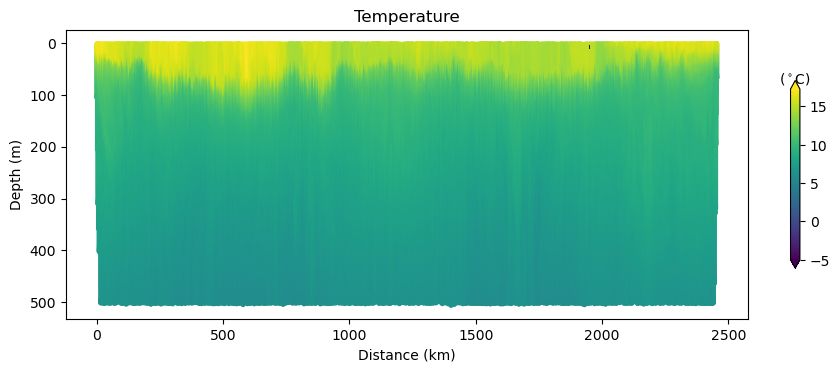

In [5]:
temp = ds.cf["sea_water_temperature"]
x = temp.cf["X"].squeeze()
y = temp.cf["Y"].squeeze()
z = temp.cf["Z"].squeeze()
t = temp.cf["T"].squeeze()

vmin, vmax = z.attrs["actual_range"]
z = np.ma.masked_outside(z.to_numpy(), vmin, vmax)

fig, ax, cbar = plot_glider(x, y, z, t, temp)
cbar.ax.set_xlabel(r"($^\circ$C)")
cbar.ax.xaxis.set_label_position("top")
ax.set_title("Temperature");

There are many things the user can do with the API.
Here is another example that finds all glider deployments within a boundary box.

In [6]:
bbox = [[-125.72, 32.60], [-117.57, 36.93]]

The cell below defines two helper functions to parse the geometry from the JSON and convert the trajectory to a shapely `LineString` to prepare the data for GIS operations later.

In [7]:
from shapely.geometry import LineString


def parse_geometry(geometry):
    """
    Filters out potentially bad coordinate pairs as returned from
    GliderDAC. Returns a safe geometry object.

    :param dict geometry: A GeoJSON Geometry object

    """
    for geom in geometry["features"]:
        if geom["geometry"]["type"] == "LineString":
            coordinates = geom["geometry"]["coordinates"]
            break

    coords = []
    for lon, lat in coordinates:
        if lon is None or lat is None:
            continue
        coords.append([lon, lat])
    return {"coordinates": coords}


def fetch_trajectory(deployment):
    """
    Downloads the track as GeoJSON from GliderDAC

    :param dict deployment: The deployment object as returned from GliderDAC

    """
    track_url = f"https://gliders.ioos.us/status/api/tracks.php?dataset_id={deployment['name']}&type=full"
    response = requests.get(track_url)
    if response.status_code != 200:
        raise OSError(
            "Failed to get Glider Track for %s" % deployment["deployment_dir"]
        )
    geometry = parse_geometry(response.json())
    coords = LineString(geometry["coordinates"])
    return coords

Now it is easy to check which tracks lie inside the box.

In [8]:
res = response.json()["results"]
len(res[-100:])

100

In [9]:
from shapely.geometry import box

search_box = box(bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1])

inside = dict()
# Getting only the first 20 deployments.
for deployment in response.json()["results"][0:21]:
    try:
        coords = fetch_trajectory(deployment)
    except OSError:
        continue
    if search_box.intersects(coords):
        inside.update({deployment["name"]: coords})

Finally, we can create an interactive map displaying the tracks found in the bounding box.

In [10]:
def plot_track(coords, name, color="orange"):
    x, y = coords.xy
    locations = list(zip(y.tolist(), x.tolist()))
    kw = {"fill": True, "radius": 10, "stroke": False}
    folium.CircleMarker(locations[0], color="green", **kw).add_to(m)
    folium.CircleMarker(locations[-1], color="red", **kw).add_to(m)

    folium.PolyLine(
        locations=locations, color=color, weight=8, opacity=0.2, popup=name
    ).add_to(m)

In [11]:
import folium

tiles = (
    "http://services.arcgisonline.com/arcgis/rest/services/"
    "World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}"
)

location = [search_box.centroid.y, search_box.centroid.x]

m = folium.Map(location=location, zoom_start=5, tiles=tiles, attr="ESRI")


for name, coords in inside.items():
    plot_track(coords, name, color="orange")


m